In [1]:
import json
import numpy as np
from pathlib import Path
import scipy.stats as stats
from statistics import mean, stdev
import statsmodels.stats.multicomp as mc
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

'''
This script analyzes energy expenditure from polar data. Scripts goes through all data from data dump
and analyzes seasonal changes in energy expenditure.
'''

# Directory path for dataset
path = r'C:\Users\Käyttäjä\DataProjects\DataProjects\data\polar_datadump'
directory = Path(path)

#Choose the starting year for analysis
start_date = "2018"

files = []
# Loop through all files in the directory
for file in directory.iterdir():
    # Check if the file is a activity file
    if file.is_file() and "activity" in file.name: #and vuosi in file.name:
        files.append(file.name)

print(len(files))

2613


In [2]:
#Collect MET values from the files and calculate daily energy expenditure. Add the dates and energy expenditures to a list.

energies = []
for file in files:
    dailyenergy = []
    totalenergy = 0
    pathsession = path + '\\' + file
    f = open(pathsession)
    data = json.load(f)
    date = data['date']
    date = datetime.strptime(date, "%Y-%m-%d")
    if date < datetime(2018, 1, 1):
        continue
    bodyweight = data['physicalInformation']['weight, kg']
    dailyenergy.append(date)
    mets_values = [sample['value'] for sample in data['samples']['mets']]
    for value in mets_values:    
        totalenergy = totalenergy + value * 0.5 * bodyweight / 60
    if totalenergy < 2000: continue
    dailyenergy.append(totalenergy)
    energies.append(dailyenergy)


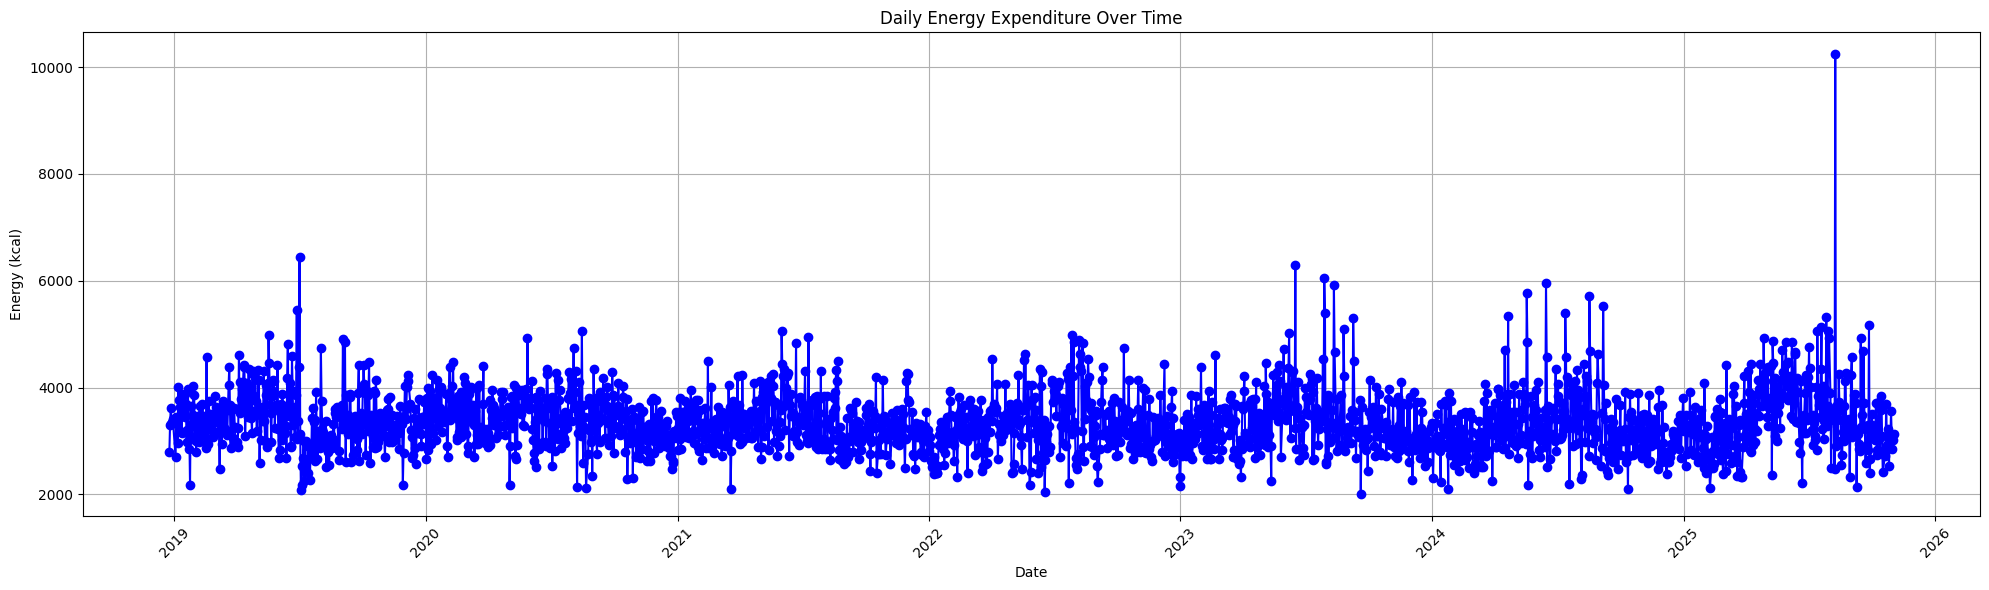

In [3]:
# Separate dates and energy values for plotting
dates = [entry[0] for entry in energies]

energy_values = [entry[1] for entry in energies]

# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(dates, energy_values, marker='o', linestyle='-', color='b')
plt.title('Daily Energy Expenditure Over Time')
plt.xlabel('Date')
plt.ylabel('Energy (kcal)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
#Collect only the month from dates to calculate monthly averages
for i in range(len(energies)):
    month = energies[i][0].month 
    energies[i][0] = month
#print(energies)


tunnusluvut = [[],[],[],[],[],[],[],[],[],[],[],[]]
arvot = [[],[],[],[],[],[],[],[],[],[],[],[]] 

#add values to a list depending on the month. Months are marked by indexes of the list
for value in energies:
    kuukausi = int(value[0])
    arvot[kuukausi - 1].append(value[1])

#Calcualet means and SDs for monthly energy expenditure
tulokset = []
for i in range(len(arvot)):
    ka = mean(arvot[i])
    sd = stdev(arvot[i])
    tunnusluvut[i].append(ka)
    tunnusluvut[i].append(sd)

#print(tunnusluvut)

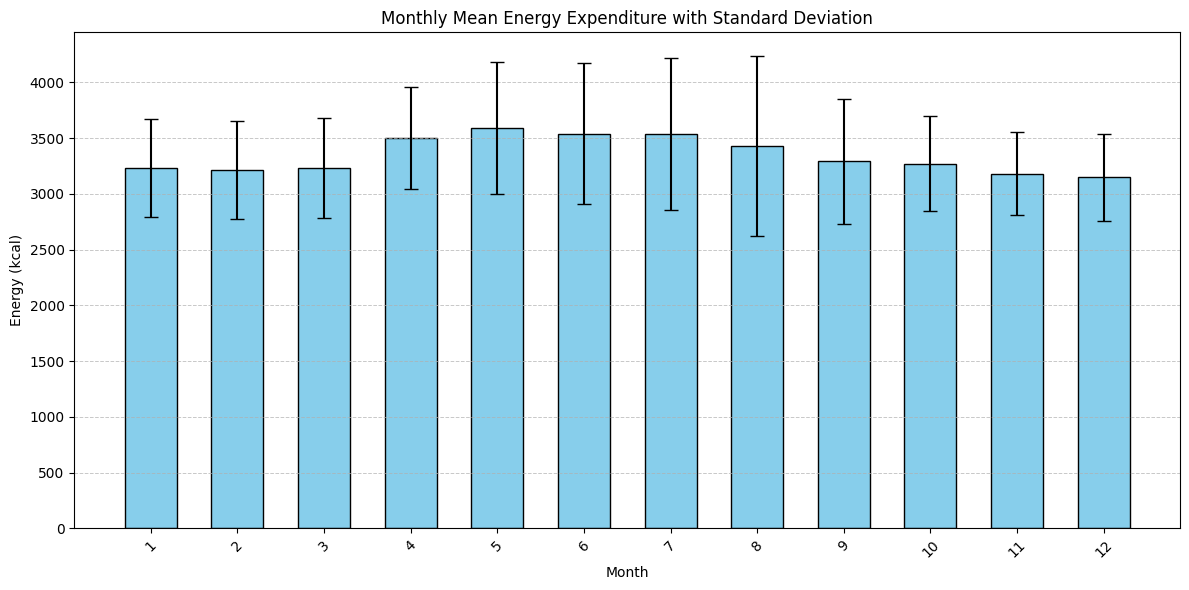

In [5]:
# Separate the means and standard deviations
means = [item[0] for item in tunnusluvut]
stdevs = [item[1] for item in tunnusluvut]

# Create x-axis labels
labels = [f'{i+1}' for i in range(len(tunnusluvut))]

# Set up the bar plot
x = np.arange(len(tunnusluvut))  # Ensure this has the same length as data
width = 0.6  # Width of the bars

# Plotting the bar graph with error bars
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x, means, width, yerr=stdevs, capsize=5, color='skyblue', edgecolor='black')

# Adding labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Energy (kcal)')
ax.set_title('Monthly Mean Energy Expenditure with Standard Deviation')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding a grid
ax.yaxis.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
#Lets do the same as previously but now separating data by seasons.

kuukausiarvot = [[],[],[],[]]
tunnusluvut = [[],[],[],[]]

for arvo in energies:
    arvo[0] = int(arvo[0])
    
for arvo in energies:
    if arvo[0] in (12, 1, 2):
        kuukausiarvot[0].append(arvo[1])
    if arvo[0] in (3, 4, 5):
        kuukausiarvot[1].append(arvo[1])
    if arvo[0] in (6, 7, 8):
        kuukausiarvot[2].append(arvo[1])
    if arvo[0] in (9, 10, 11):
        kuukausiarvot[3].append(arvo[1])

for i in range(len(kuukausiarvot)):
    ka = mean(kuukausiarvot[i])
    sd = stdev(kuukausiarvot[i])
    tunnusluvut[i].append(ka)
    tunnusluvut[i].append(sd)

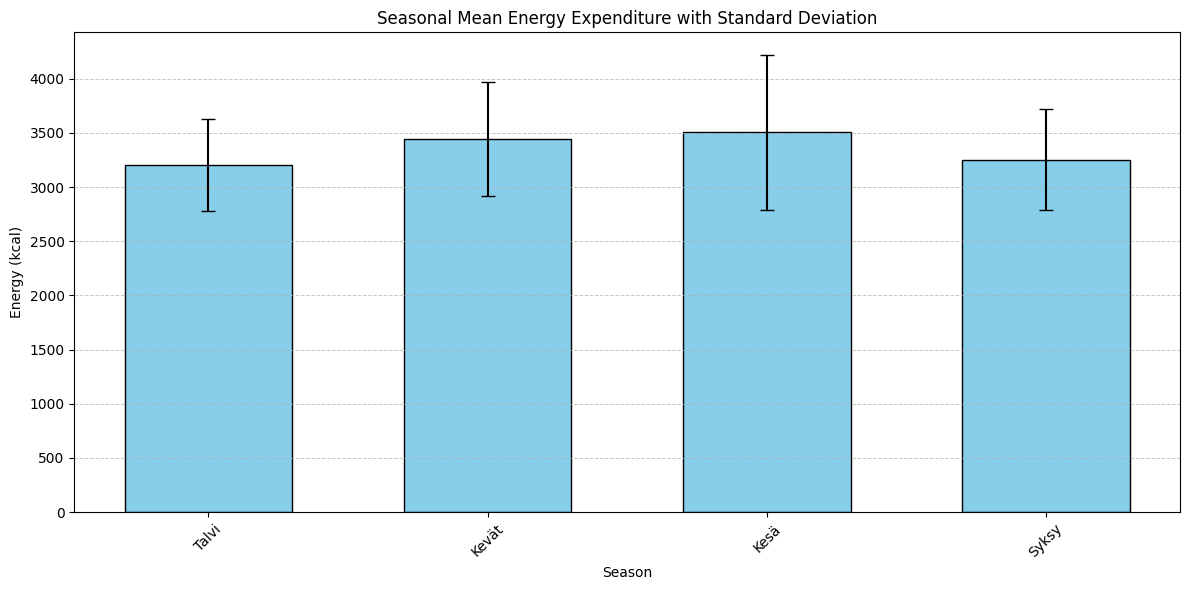

In [7]:
# Separate the means and standard deviations
means = [item[0] for item in tunnusluvut]
stdevs = [item[1] for item in tunnusluvut]

# Create x-axis labels
labels = ["Talvi", "Kevät", "Kesä", "Syksy"]

# Set up the bar plot
x = np.arange(len(tunnusluvut))  # Ensure this has the same length as data
width = 0.6  # Width of the bars

# Plotting the bar graph with error bars
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x, means, width, yerr=stdevs, capsize=5, color='skyblue', edgecolor='black')

# Adding labels and title
ax.set_xlabel('Season')
ax.set_ylabel('Energy (kcal)')
ax.set_title('Seasonal Mean Energy Expenditure with Standard Deviation')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding a grid
ax.yaxis.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Run anova and post hoc for seasonal

In [8]:
#Separate monthly values to own variables
talvi = kuukausiarvot[0]
kevät = kuukausiarvot[1]
kesä = kuukausiarvot[2]
syksy = kuukausiarvot[3]

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(talvi, kevät, kesä, syksy)

print(f'F-value: {f_value}')
print(f'P-value: {p_value}')

# Check if the result is statistically significant
alpha = 0.05
if p_value < alpha:
    print("The differences between the groups are statistically significant.")
else:
    print("The differences between the groups are not statistically significant.")

F-value: 42.92088987099281
P-value: 5.100715500536395e-27
The differences between the groups are statistically significant.


In [9]:
# Combine data into a single array and create group labels
data = talvi + kevät + kesä + syksy
groups = ['Talvi']*len(talvi) + ['Kevät']*len(kevät) + ['Kesä']*len(kesä) + ['Syksy']*len(syksy)

# Create a DataFrame
df = pd.DataFrame({'Energy': data, 'Season': groups})

# Perform Tukey's HSD test
tukey = mc.pairwise_tukeyhsd(df['Energy'], df['Season'], alpha=0.05)

print(f'Keskiarvokulutus: {round(mean(energy_values))}')
print(f'Keskihajonta: {round(stdev(energy_values))}\n')
print('Talvi Kevät Kesä Syksy')
print('----------------------')
print(f'{round(mean(talvi))}  {round(mean(kevät))}  {round(mean(kesä))}  {round(mean(syksy))} \n')
print(tukey)



Keskiarvokulutus: 3353
Keskihajonta: 559

Talvi Kevät Kesä Syksy
----------------------
3201  3440  3504  3253 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
  Kesä  Kevät  -63.7708 0.1641 -143.0656   15.5239  False
  Kesä  Syksy -251.3682    0.0 -332.2345 -170.5019   True
  Kesä  Talvi -302.7193    0.0  -383.656 -221.7826   True
 Kevät  Syksy -187.5974    0.0 -267.7126 -107.4821   True
 Kevät  Talvi -238.9485    0.0 -319.1347 -158.7623   True
 Syksy  Talvi  -51.3511 0.3702 -133.0918   30.3895  False
---------------------------------------------------------
